In [1]:
from Gian_experimental.NSGAIICustom.CustomOperators import NCSamplerFromPRef, NCMutationCounterproductive, \
    NCCrossoverTransition
from Gian_experimental.NSGAIICustom.NSGAIICustom import EvaluatedNCSolution, NCSamplerSimple, NCMutationSimple, \
    NCCrossoverSimple
from scipy.stats import ks_2samp, wasserstein_distance
from Gian_experimental.NSGAIICustom.testing_in_vitro.testing_operators_in_vitro import make_metrics_cached

#dir_250 = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting\250"
# dir_250 = r"/Users/gian/PycharmProjects/PSSearch/data/retail_forecasting/250"

data_path = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting"
import heapq
import itertools
import json
import random
from typing import Iterable, Optional, Iterator

import numpy as np

import utils
from Gian_experimental.NSGAIICustom.testing_in_vitro.SPRef import SPRef, OptimisedSPref
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities, get_transition_matrix
from PolishSystem.read_data import get_pRef_from_vectors
import os
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import get_transition_matrix
from typing import Iterable
import heapq

def in_path(path):
    return os.path.join(data_path, path)

n = 1000

train_pRef = get_pRef_from_vectors(name_of_vectors_file=in_path(f"train_many_hot_vectors_{n}_random.csv"),
                                   name_of_fitness_file=in_path(f"train_fitness_{n}_random.csv"),
                                   column_in_fitness_file=2)
test_pRef =  get_pRef_from_vectors(name_of_vectors_file=in_path(f"test_many_hot_vectors_{n}_random.csv"),
                                   name_of_fitness_file=in_path(f"test_fitness_{n}_random.csv"),
                                   column_in_fitness_file=2)

train_SPRef = OptimisedSPref.from_pRef(train_pRef)
test_SPRef = OptimisedSPref.from_pRef(test_pRef)

cluster_info_file_name = in_path(f"cluster_info_{n}_random.pkl")
similarities = gian_get_similarities(cluster_info_file_name)



def keep_with_best_first_metric(population: Iterable[EvaluatedNCSolution], quantity_required: int):
    return heapq.nsmallest(iterable=population, key=lambda x: x.fitnesses[0], n=quantity_required)

transition_matrix = get_transition_matrix(similarities)
custom_sampling = NCSamplerFromPRef.from_PRef(train_pRef)
custom_mutation = NCMutationCounterproductive(transition_matrix)
custom_crossover = NCCrossoverTransition(transition_matrix)

def atomicity(ps):
    if len(ps) < 2:
        return -1000
    else:
        linkages = [similarities[a, b] for a, b in itertools.combinations(ps, r=2)]
        return np.average(linkages)

traditional_sampling = NCSamplerSimple.with_average_quantity(3, genome_size=n)
traditional_mutation = NCMutationSimple(n)
traditional_crossover = NCCrossoverSimple(swap_probability=1 / n)




In [57]:
from Gian_experimental.NSGAIICustom.evolving_genome_threshold import NCSolutionWithGT, SimpleSampleGT, SimpleMutateGT, \
    SimpleCrossoverGT
from scipy.stats import mannwhitneyu
from Gian_experimental.NSGAIICustom.NSGAIICustom import NCSolution, NSGAIICustom



def get_metrics(ps: NCSolutionWithGT) -> tuple[float]:
    matching, non_matching = train_SPRef.partition(ps, threshold=ps.genome_threshold)
    if len(matching) < 1000: # a constraint
        return 1000, 1000, 1000, 1000

    median_diff = np.median(matching) - np.median(non_matching)
    atomicity_score = atomicity(ps)
    
    return (len(ps), -len(matching), -median_diff, -atomicity_score)


mutation_with_gt = SimpleMutateGT(traditional_mutation)
mutation_with_gt.probability_of_change = 0.1
algorithm = NSGAIICustom(sampling=SimpleSampleGT(traditional_sampling),
                         mutation=mutation_with_gt,
                         crossover=SimpleCrossoverGT(traditional_crossover),
                         probability_of_crossover=0.5,
                         eval_budget=5000,
                         pop_size=100,
                         tournament_size=3,
                         mo_fitness_function=make_metrics_cached(get_metrics),
                         unique=True,
                         verbose=True,
                         culler=keep_with_best_first_metric
                         )

In [58]:
results  = algorithm.run()

NSGAIICustom -> Beginning of NC process
NSGAIICustom -> Used evals: 214
NSGAIICustom -> Used evals: 319
NSGAIICustom -> Used evals: 428
NSGAIICustom -> Used evals: 543
NSGAIICustom -> Used evals: 650
NSGAIICustom -> Used evals: 761
NSGAIICustom -> Used evals: 867
NSGAIICustom -> Used evals: 980
NSGAIICustom -> Used evals: 1089
NSGAIICustom -> Used evals: 1198
NSGAIICustom -> Used evals: 1306
NSGAIICustom -> Used evals: 1422
NSGAIICustom -> Used evals: 1538
NSGAIICustom -> Used evals: 1640
NSGAIICustom -> Used evals: 1750
NSGAIICustom -> Used evals: 1866
NSGAIICustom -> Used evals: 1972
NSGAIICustom -> Used evals: 2082
NSGAIICustom -> Used evals: 2188
NSGAIICustom -> Used evals: 2296
NSGAIICustom -> Used evals: 2407
NSGAIICustom -> Used evals: 2522
NSGAIICustom -> Used evals: 2627
NSGAIICustom -> Used evals: 2737
NSGAIICustom -> Used evals: 2843
NSGAIICustom -> Used evals: 2954
NSGAIICustom -> Used evals: 3060
NSGAIICustom -> Used evals: 3172
NSGAIICustom -> Used evals: 3276
NSGAIICusto

There are 120 results
(4, -1030, -2.051422119140625, -0.5345059) 4
(4, -7799, -0.8594827651977539, 0.8291559) 4
(5, -1284, -1.973982810974121, -0.002953504) 5
(5, -5006, -1.108780860900879, -0.2673353) 5
(1, -1587, -1.4973080158233643, 1000) 1
(10, -13655, -0.7963321208953857, -0.38184118) 10
(10, -2631, -1.8273425102233887, -0.750357) 10
(11, -10632, -0.8135571479797363, -0.8998644) 11
(5, -8494, -0.9141750335693359, 0.11025294) 5
(6, -10010, -0.7604763507843018, -1.5025071) 6
(3, -2146, -1.3504858016967773, -1.1734666) 3
(13, -2514, -2.1190667152404785, -0.8758282) 13
(3, -4253, -0.87642502784729, -5.3838334) 3
(4, -3464, -1.2451720237731934, -2.852681) 4
(5, -1310, -1.811793327331543, -1.4874153) 5
(2, -3236, -1.0374398231506348, -1.2815338) 2
(12, -2651, -2.0170555114746094, -0.24949336) 12
(4, -4507, -0.8039114475250244, -1.997707) 4
(4, -10605, -0.8296046257019043, -0.41968584) 4
(5, -1077, -2.9821512699127197, -0.053237937) 5
(5, -2575, -1.5086793899536133, -1.9482673) 5
(5, -35

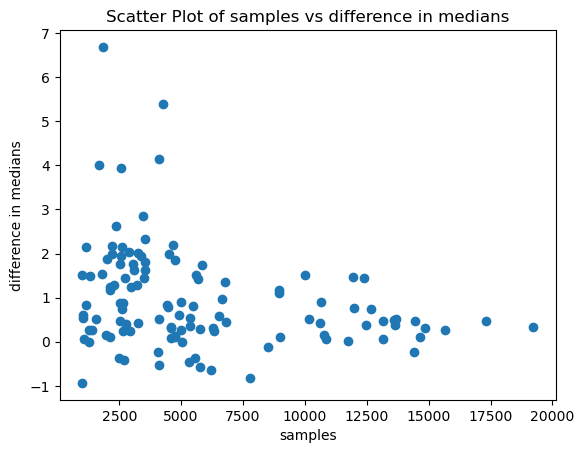

In [52]:
print(f"There are {len(results)} results")

for result in results:
    print(result.fitnesses, len(result.solution))
    
    
    
col_a = 1
col_b = 3
vals_a = [-ps.fitnesses[col_a] for ps in results if len(ps.solution) > 1]
vals_b = [-ps.fitnesses[col_b] for ps in results if len(ps.solution) > 1]

utils.simple_scatterplot(x_label="samples", y_label="difference in medians", xs=vals_a, ys=vals_b)

In [12]:


from matplotlib import pyplot as plt
from Gian_experimental.plotting_utils import display_side_by_side

def compare_histograms(
    data1,
    data2,
    bins=30,
    log_x=False,
    log_y=False,
    labels=("Data 1", "Data 2"),
    title="Histogram Comparison",
    figsize=(6, 4),
    ax=None,
    y_axis_frequency="absolute",  # "absolute" or "relative"
):
    """
    Creates a histogram comparison plot of two datasets on a given Axes or a new figure.

    Parameters:
        ...
        y_axis_frequency (str): "absolute" for counts, "relative" for percentages (0–100%).

    Returns:
        matplotlib.figure.Figure or None
    """
    data1 = np.array(data1)
    data2 = np.array(data2)

    if log_x:
        data1 = data1[data1 > 0]
        data2 = data2[data2 > 0]
        combined = np.concatenate([data1, data2])
        min_val = combined.min()
        max_val = combined.max()
        bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None

    density = y_axis_frequency == "relative"

    ax.hist(data1, bins=bins, alpha=0.5, label=labels[0], edgecolor='black', density=density)
    ax.hist(data2, bins=bins, alpha=0.5, label=labels[1], edgecolor='black', density=density)

    if log_x:
        ax.set_xscale('log')
    if log_y:
        ax.set_yscale('log')

    ax.set_xlabel("Value")
    ax.set_ylabel("Percentage" if density else "Frequency")

    if density:
        # Convert y-axis to percentage
        ticks = ax.get_yticks()
        ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])

    ax.set_title(title)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    return fig

def display_side_by_side(histogram_args_list, figsize_per_plot=(5, 5)):
    """
    Displays multiple histograms side-by-side using `compare_histograms`.

    Parameters:
        histogram_args_list (list[dict]): Each dict contains args for `compare_histograms`.
        figsize_per_plot (tuple): Size per individual plot; used to scale total figure.
    """
    num = len(histogram_args_list)
    total_figsize = (figsize_per_plot[0] * num, figsize_per_plot[1])
    fig, axs = plt.subplots(1, num, figsize=total_figsize)

    if num == 1:
        axs = [axs]  # Ensure it's iterable

    for args, ax in zip(histogram_args_list, axs):
        compare_histograms(ax=ax, **args)

    plt.tight_layout()
    plt.show()


def get_textual_description_of_distribution(values):
    return (f"n = {len(values)},\n"
              f"average = {np.average(values):.2f}, median = {np.median(values):.2f}\n"
              f"min = {np.min(values):.2f}, max = {np.max(values):.2f},\n")

def make_ps_into_explanation(ps: NCSolutionWithGT, test_SPref: SPRef):
    print(f"If you match this list of {len(ps)}, with threshold {ps.genome_threshold}:")
    print(ps)
    

    match_fitnesses, match_non_fitnesses = test_SPref.partition(ps, ps.genome_threshold)
    
    if len(match_fitnesses) < 100 or len(match_non_fitnesses) < 100:
        print(f"There are not enough matches!!!  {len(match_fitnesses)}, {len(match_non_fitnesses)}")
        return
    distance = wasserstein_distance(match_fitnesses, match_non_fitnesses)
    
    print(f"The Wasserstein distance is {distance}")
    print("Distribution of match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_fitnesses)))
    print("Distribution of non match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_non_fitnesses)))
    
    display_side_by_side([
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Fitnesses of matches vs non-matches",
                "labels": ("Matches", "Non matches"),
                "y_axis_frequency": "relative"
            },
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Absolute view",
                "labels": ("Matches", "Non Matches"),
                "y_axis_frequency": "absolute"
            }
        ])

0 {297, 236, 750, 404}, gt=2
1 {224, 488, 954, 677}, gt=1
2 {979, 852, 118, 842, 750}, gt=2
3 {17, 605, 38, 509, 591}, gt=1
4 {38}, gt=1
5 {641, 740, 297, 236, 332, 750, 530, 115, 404, 319}, gt=1
6 {224, 291, 677, 903, 488, 490, 651, 76, 569, 954}, gt=2
7 {34, 643, 838, 267, 782, 144, 145, 179, 629, 790, 603}, gt=1
8 {224, 677, 903, 488, 954}, gt=1
9 {129, 852, 277, 842, 298, 750}, gt=1
10 {113, 102, 734}, gt=1
11 {34, 643, 645, 838, 360, 267, 782, 144, 145, 179, 629, 790, 603}, gt=2
12 {817, 283, 22}, gt=1
13 {339, 799, 734, 475}, gt=1
14 {102, 215, 203, 397, 734}, gt=2
15 {368, 734}, gt=1
16 {160, 288, 668, 577, 171, 750, 213, 54, 503, 731, 700, 382}, gt=2
17 {32, 910, 734, 359}, gt=1
18 {842, 979, 852, 750}, gt=1
19 {947, 345, 105, 891, 158}, gt=2
20 {852, 822, 918, 842, 750}, gt=2
21 {947, 5, 345, 891, 670}, gt=1
22 {605, 38}, gt=1
23 {345, 891, 947, 191}, gt=1
24 {690, 907, 734}, gt=1
25 {144, 145, 819, 70, 603, 782, 591}, gt=2
26 {194, 547, 644, 360, 333, 851, 380, 830}, gt=2
27 

C:\Users\gac8\AppData\Local\Temp\ipykernel_12500\1072996255.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])


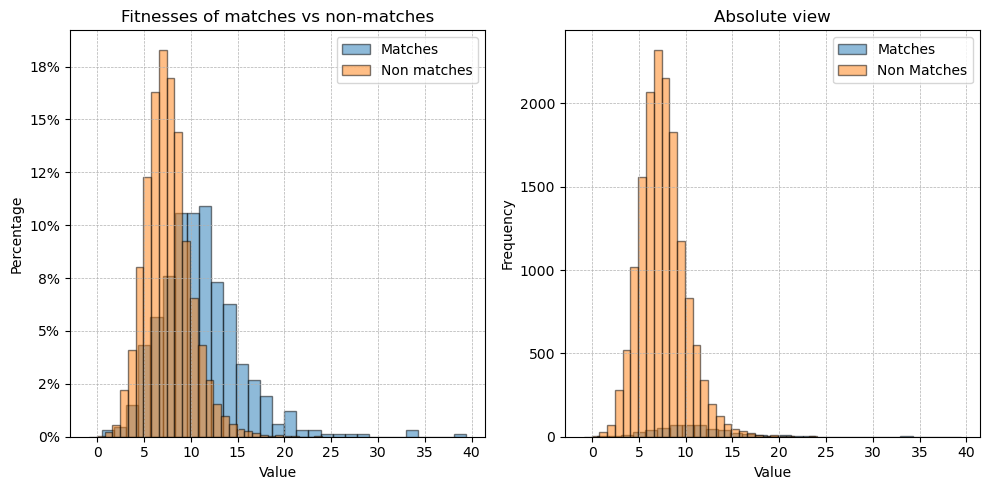

The metrics were (10, -1791, -2.316699981689453, -1.5307746)
If you match this list of 10, with threshold 2:
{547, 644, 713, 333, 81, 977, 117, 667, 380, 830}, gt=2
The Wasserstein distance is 2.6906191555501335
Distribution of match fitness
	n = 757,
	average = 10.20, median = 9.63
	min = 1.57, max = 33.75,
	
Distribution of non match fitness
	n = 15041,
	average = 7.51, median = 7.31
	min = -0.89, max = 39.44,
	


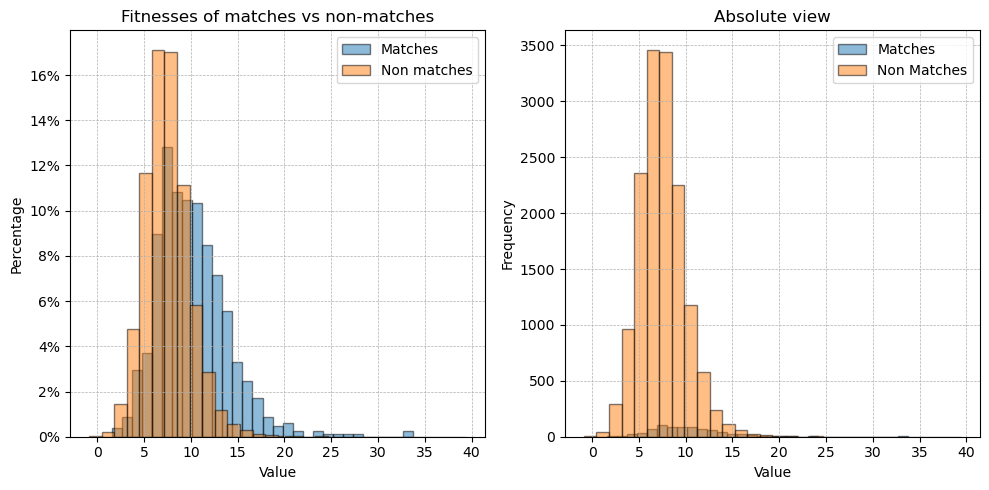

The metrics were (4, -1030, -2.051422119140625, -0.5345059)
If you match this list of 4, with threshold 2:
{297, 236, 750, 404}, gt=2
The Wasserstein distance is 2.4862494128910795
Distribution of match fitness
	n = 502,
	average = 10.05, median = 9.54
	min = 2.88, max = 33.75,
	
Distribution of non match fitness
	n = 15296,
	average = 7.56, median = 7.34
	min = -0.89, max = 39.44,
	


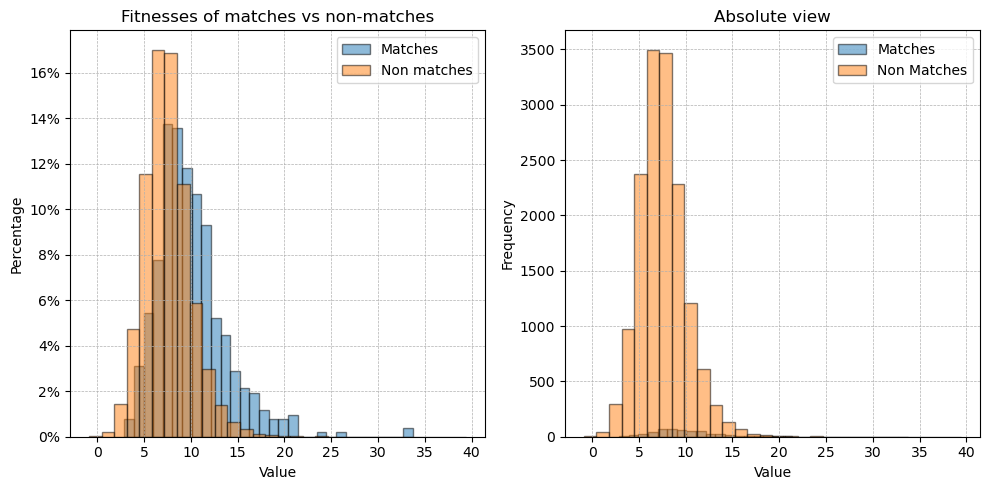

The metrics were (10, -2631, -1.8273425102233887, -0.750357)
If you match this list of 10, with threshold 2:
{224, 291, 677, 903, 488, 490, 651, 76, 569, 954}, gt=2
The Wasserstein distance is 2.1601499381313176
Distribution of match fitness
	n = 1123,
	average = 9.65, median = 9.21
	min = 2.10, max = 33.75,
	
Distribution of non match fitness
	n = 14675,
	average = 7.49, median = 7.29
	min = -0.89, max = 39.44,
	


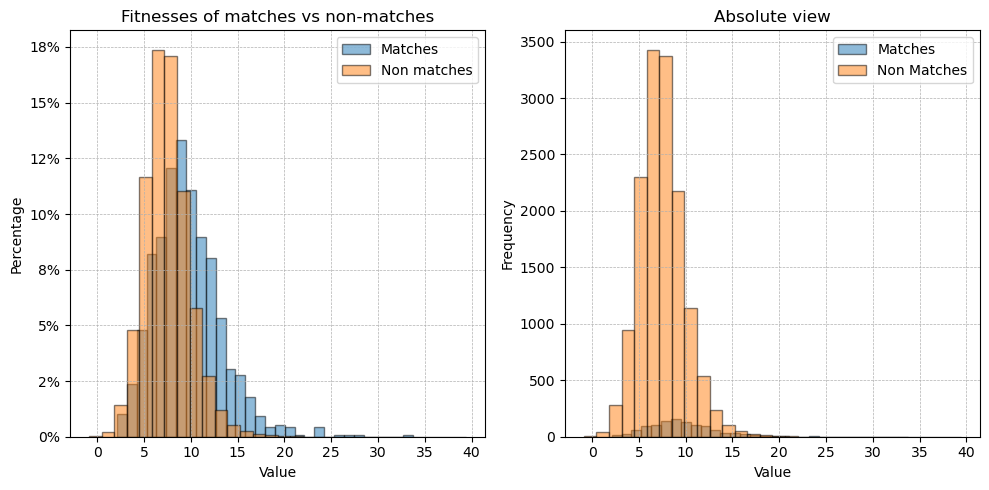

The metrics were (9, -2948, -1.7060832977294922, -0.24143155)
If you match this list of 9, with threshold 2:
{672, 804, 230, 807, 200, 460, 13, 526, 915}, gt=2
The Wasserstein distance is 2.1900260106259086
Distribution of match fitness
	n = 1216,
	average = 9.66, median = 9.10
	min = 1.11, max = 33.75,
	
Distribution of non match fitness
	n = 14582,
	average = 7.47, median = 7.28
	min = -0.89, max = 39.44,
	


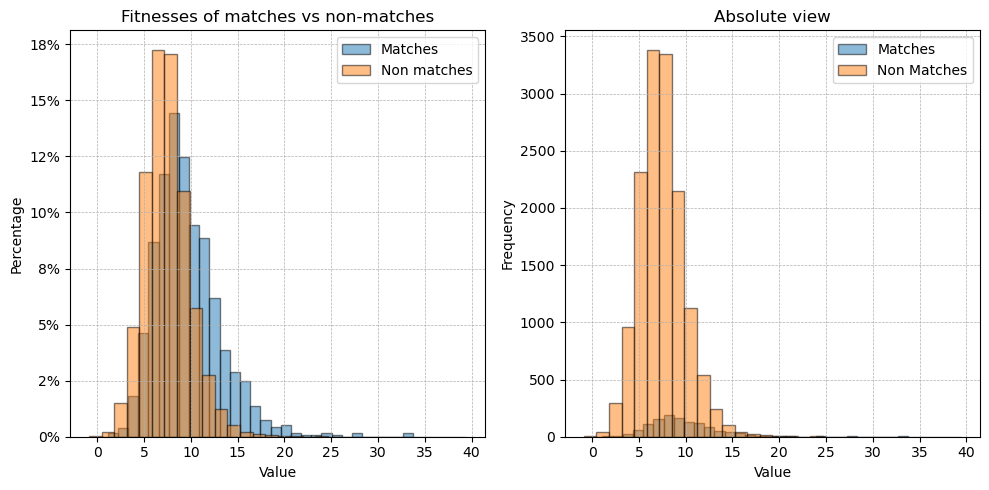

The metrics were (5, -2575, -1.5086793899536133, -1.9482673)
If you match this list of 5, with threshold 2:
{852, 822, 918, 842, 750}, gt=2
The Wasserstein distance is 1.76034613731479
Distribution of match fitness
	n = 1147,
	average = 9.27, median = 8.95
	min = 1.02, max = 25.73,
	
Distribution of non match fitness
	n = 14651,
	average = 7.51, median = 7.29
	min = -0.89, max = 39.44,
	


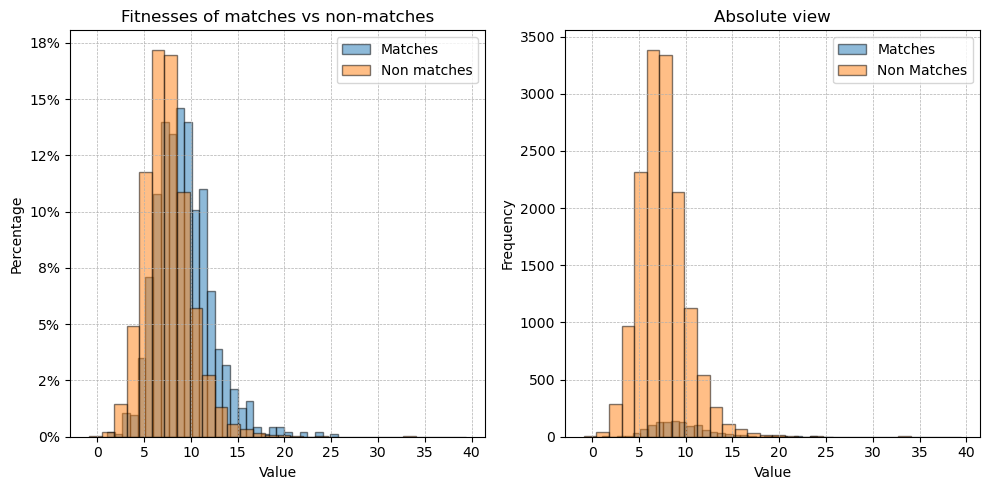

The metrics were (4, -4089, -1.4178528785705566, -0.51380914)
If you match this list of 4, with threshold 1:
{620, 453, 734, 919}, gt=1
The Wasserstein distance is 1.7350581275719938
Distribution of match fitness
	n = 1748,
	average = 9.18, median = 8.69
	min = 1.28, max = 39.44,
	
Distribution of non match fitness
	n = 14050,
	average = 7.45, median = 7.27
	min = -0.89, max = 27.25,
	


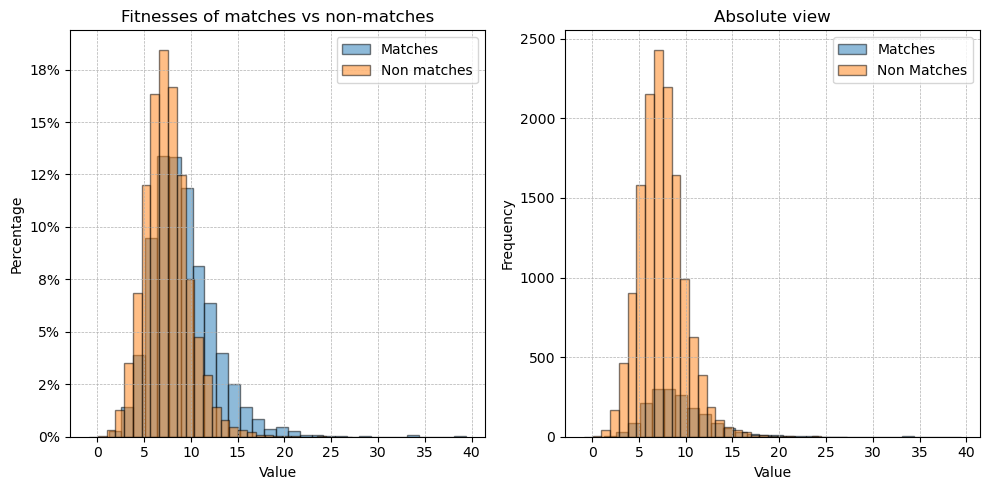

The metrics were (2, -1824, -1.3039183616638184, -6.6865478)
If you match this list of 2, with threshold 1:
{102, 734}, gt=1
The Wasserstein distance is 1.609695166367504
Distribution of match fitness
	n = 764,
	average = 9.17, median = 8.61
	min = 1.28, max = 33.43,
	
Distribution of non match fitness
	n = 15034,
	average = 7.56, median = 7.34
	min = -0.89, max = 39.44,
	


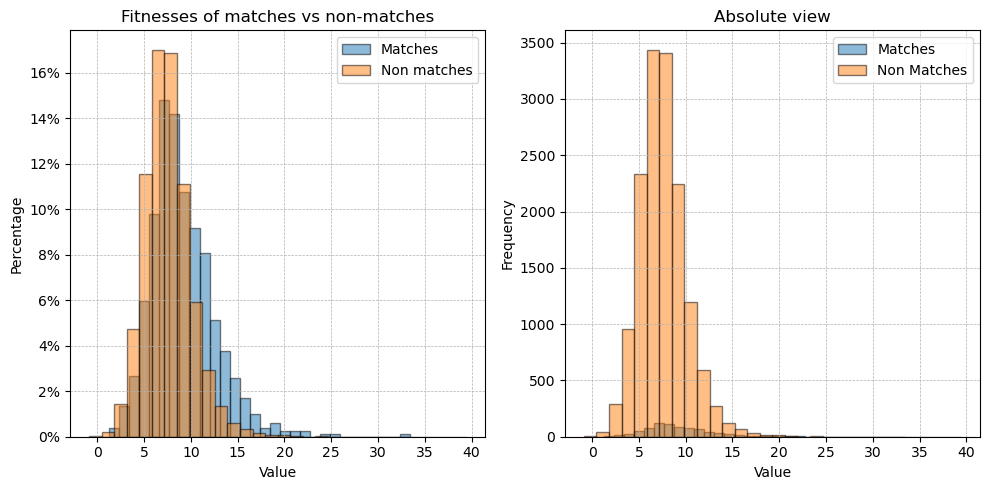

The metrics were (4, -3464, -1.2451720237731934, -2.852681)
If you match this list of 4, with threshold 1:
{339, 799, 734, 475}, gt=1
The Wasserstein distance is 1.5699906492331346
Distribution of match fitness
	n = 1458,
	average = 9.06, median = 8.47
	min = 1.28, max = 33.43,
	
Distribution of non match fitness
	n = 14340,
	average = 7.50, median = 7.30
	min = -0.89, max = 39.44,
	


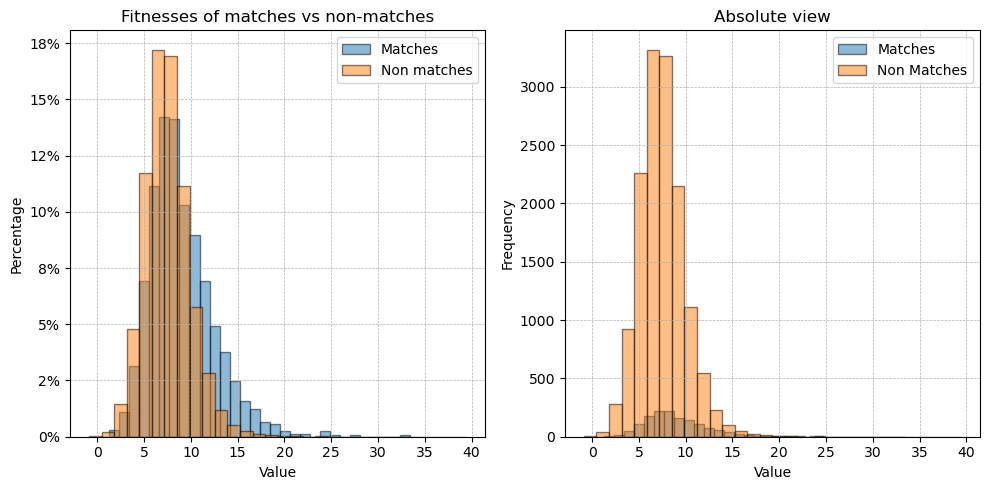

The metrics were (3, -2893, -1.1822433471679688, -2.0459468)
If you match this list of 3, with threshold 1:
{825, 102, 734}, gt=1
The Wasserstein distance is 1.5330981108158155
Distribution of match fitness
	n = 1203,
	average = 9.06, median = 8.53
	min = 1.07, max = 33.43,
	
Distribution of non match fitness
	n = 14595,
	average = 7.52, median = 7.32
	min = -0.89, max = 39.44,
	


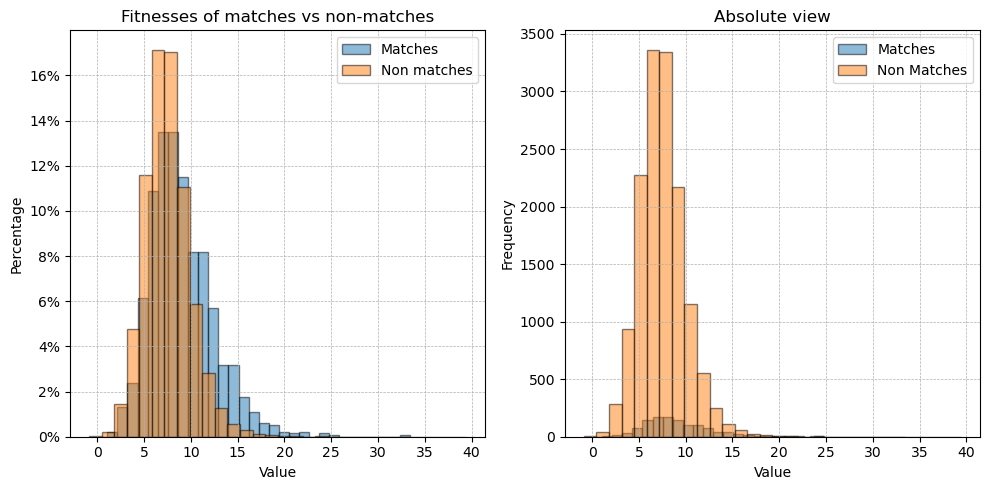

The metrics were (5, -3543, -1.1190226078033447, -2.3336818)
If you match this list of 5, with threshold 1:
{947, 5, 345, 891, 670}, gt=1
The Wasserstein distance is 1.632275587225877
Distribution of match fitness
	n = 1573,
	average = 9.11, median = 8.54
	min = 1.02, max = 39.44,
	
Distribution of non match fitness
	n = 14225,
	average = 7.48, median = 7.30
	min = -0.89, max = 24.03,
	


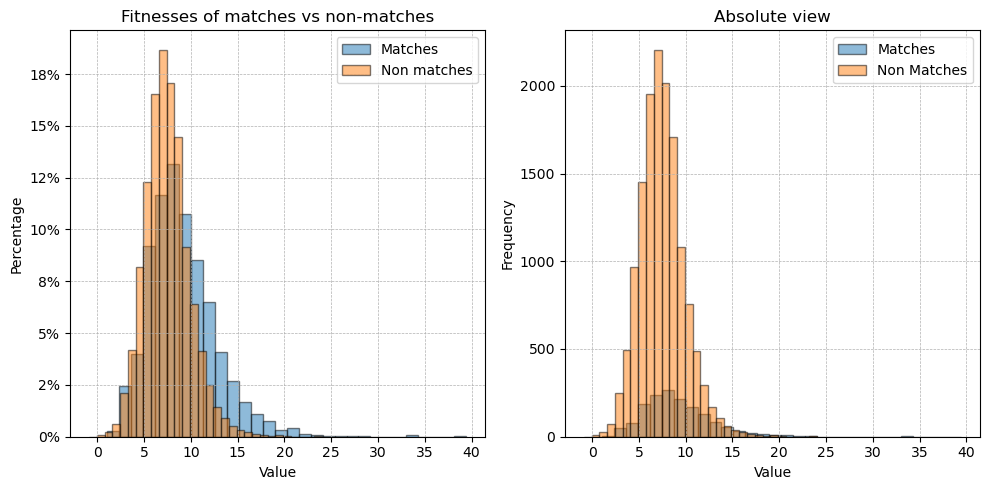

The metrics were (3, -4112, -1.0923748016357422, 0.5239016)
If you match this list of 3, with threshold 1:
{952, 203, 503}, gt=1
The Wasserstein distance is 1.3403256397082937
Distribution of match fitness
	n = 1795,
	average = 8.83, median = 8.44
	min = -0.89, max = 33.75,
	
Distribution of non match fitness
	n = 14003,
	average = 7.49, median = 7.29
	min = 0.07, max = 39.44,
	


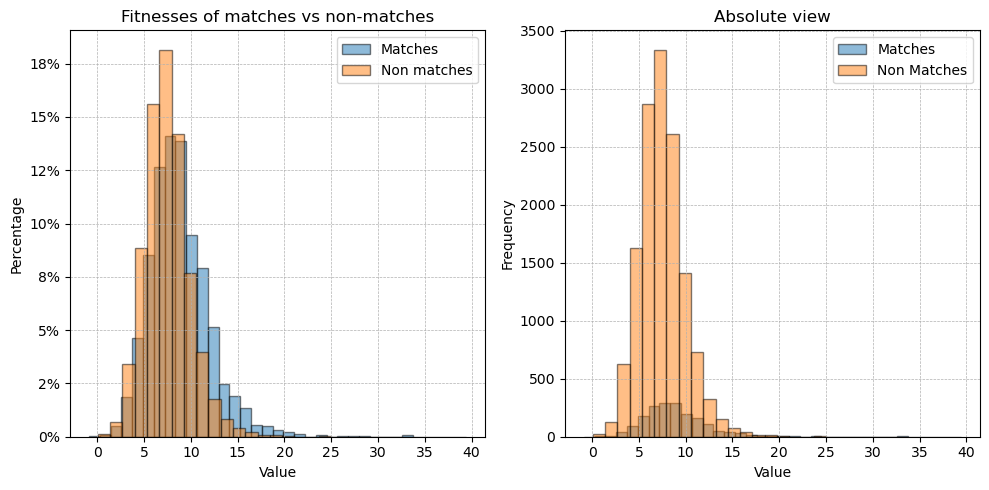

The metrics were (2, -3236, -1.0374398231506348, -1.2815338)
If you match this list of 2, with threshold 1:
{368, 734}, gt=1
The Wasserstein distance is 1.5905593698167078
Distribution of match fitness
	n = 1454,
	average = 9.08, median = 8.51
	min = 1.28, max = 39.44,
	
Distribution of non match fitness
	n = 14344,
	average = 7.49, median = 7.30
	min = -0.89, max = 27.25,
	


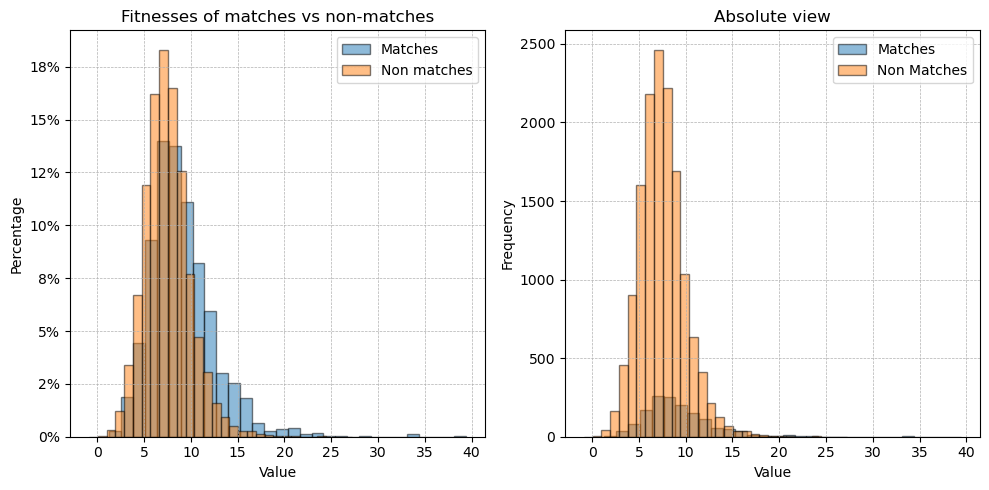

The metrics were (4, -5559, -0.990950345993042, 0.36047176)
If you match this list of 4, with threshold 1:
{952, 203, 317, 503}, gt=1
The Wasserstein distance is 1.2476419626296855
Distribution of match fitness
	n = 2415,
	average = 8.69, median = 8.31
	min = -0.89, max = 33.75,
	
Distribution of non match fitness
	n = 13383,
	average = 7.45, median = 7.26
	min = 0.07, max = 39.44,
	


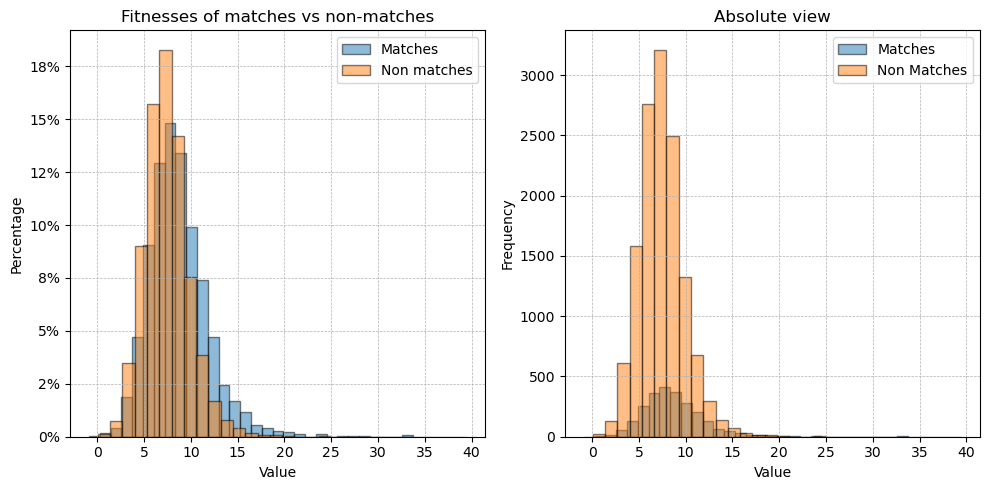

The metrics were (8, -5694, -0.9656710624694824, -1.4252015)
If you match this list of 8, with threshold 1:
{96, 71, 712, 339, 346, 475, 734, 799}, gt=1
The Wasserstein distance is 1.247088520201098
Distribution of match fitness
	n = 2442,
	average = 8.69, median = 8.19
	min = 1.00, max = 33.75,
	
Distribution of non match fitness
	n = 13356,
	average = 7.45, median = 7.27
	min = -0.89, max = 39.44,
	


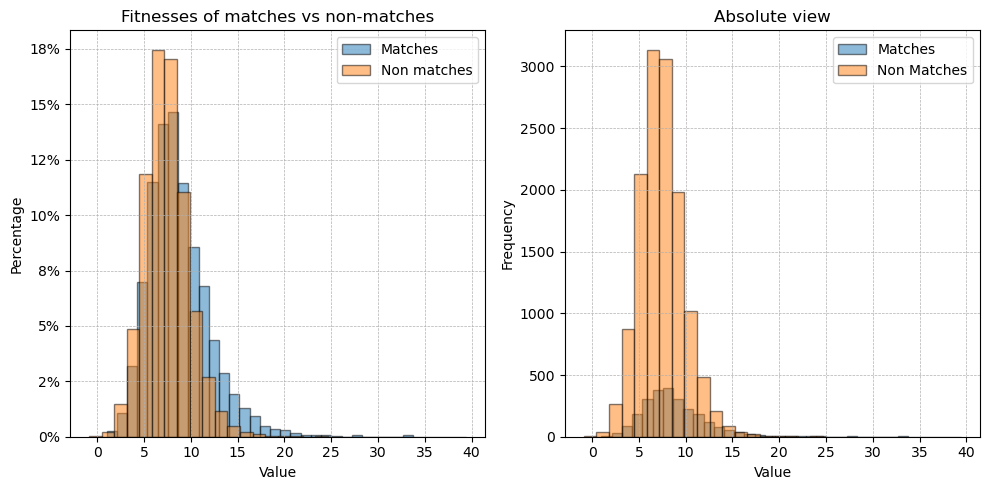

The metrics were (2, -3270, -0.9405593872070312, -0.42191142)
If you match this list of 2, with threshold 1:
{312, 793}, gt=1
The Wasserstein distance is 1.3457093634293997
Distribution of match fitness
	n = 1446,
	average = 8.86, median = 8.34
	min = 1.11, max = 33.75,
	
Distribution of non match fitness
	n = 14352,
	average = 7.52, median = 7.31
	min = -0.89, max = 39.44,
	


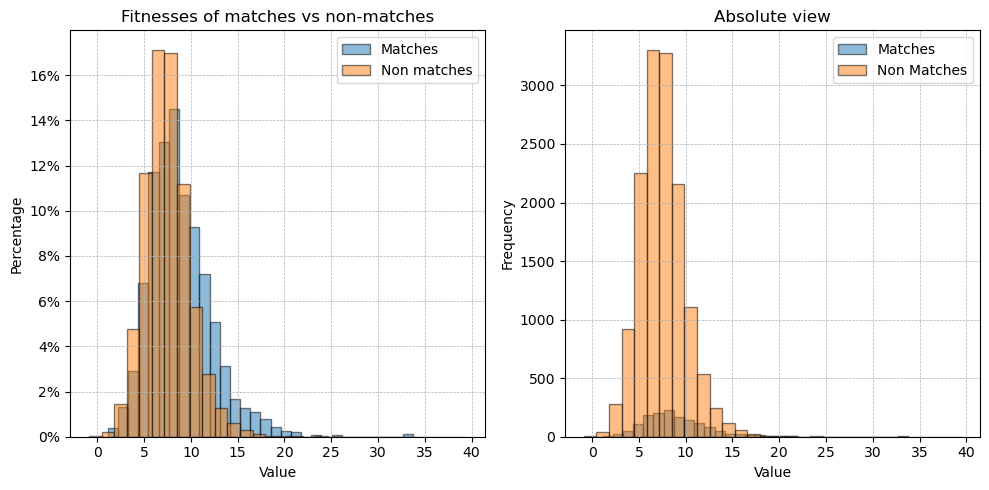

The metrics were (6, -9005, -0.9027421474456787, -0.11743219)
If you match this list of 6, with threshold 1:
{224, 530, 677, 903, 488, 954}, gt=1
The Wasserstein distance is 1.1521745842278248
Distribution of match fitness
	n = 3804,
	average = 8.51, median = 8.14
	min = -0.89, max = 39.44,
	
Distribution of non match fitness
	n = 11994,
	average = 7.36, median = 7.21
	min = 0.07, max = 33.43,
	


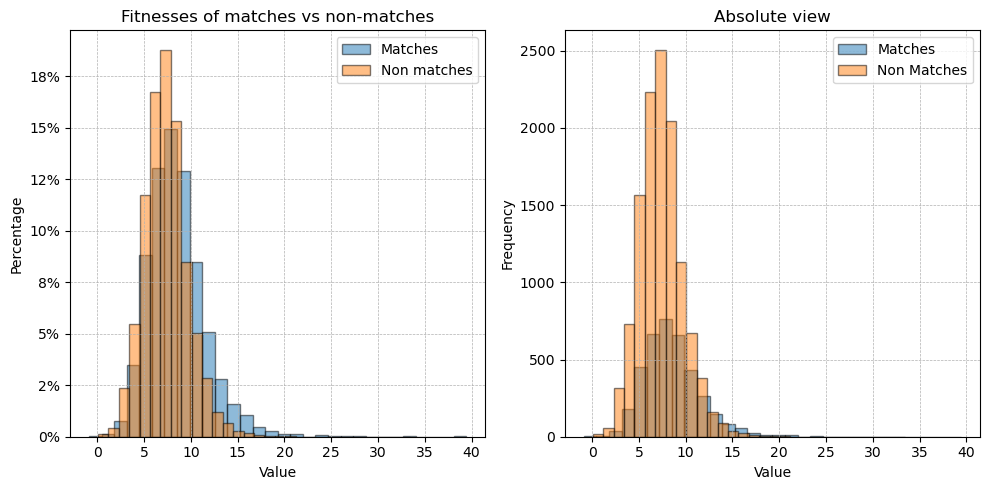

The metrics were (2, -2188, -0.875312328338623, -2.175791)
If you match this list of 2, with threshold 1:
{840, 68}, gt=1
The Wasserstein distance is 1.1286020952045355
Distribution of match fitness
	n = 964,
	average = 8.70, median = 8.25
	min = 2.01, max = 27.25,
	
Distribution of non match fitness
	n = 14834,
	average = 7.57, median = 7.33
	min = -0.89, max = 39.44,
	


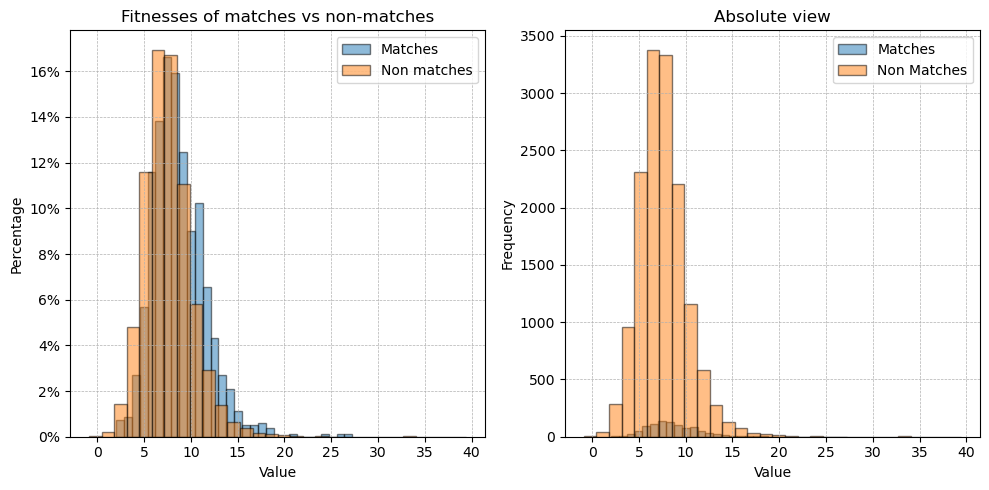

The metrics were (2, -3076, -0.8560395240783691, -1.6298991)
If you match this list of 2, with threshold 1:
{497, 283}, gt=1
The Wasserstein distance is 1.2164095160958657
Distribution of match fitness
	n = 1341,
	average = 8.75, median = 8.31
	min = 1.93, max = 25.73,
	
Distribution of non match fitness
	n = 14457,
	average = 7.54, median = 7.31
	min = -0.89, max = 39.44,
	


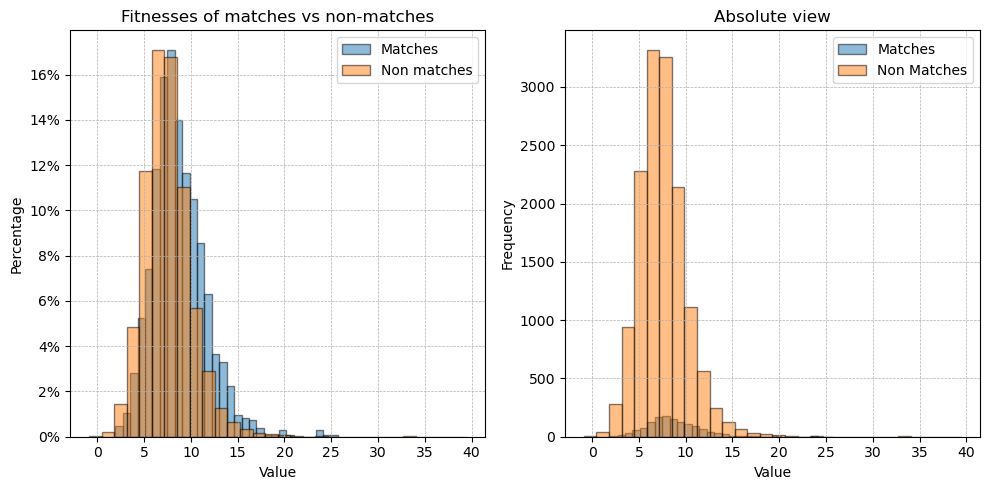

The metrics were (12, -11946, -0.8488035202026367, -1.4688618)
If you match this list of 12, with threshold 1:
{386, 739, 677, 203, 657, 113, 821, 503, 952, 666, 247, 317}, gt=1
The Wasserstein distance is 0.9943249062614853
Distribution of match fitness
	n = 5035,
	average = 8.32, median = 7.98
	min = -0.89, max = 33.75,
	
Distribution of non match fitness
	n = 10763,
	average = 7.32, median = 7.17
	min = 0.07, max = 39.44,
	


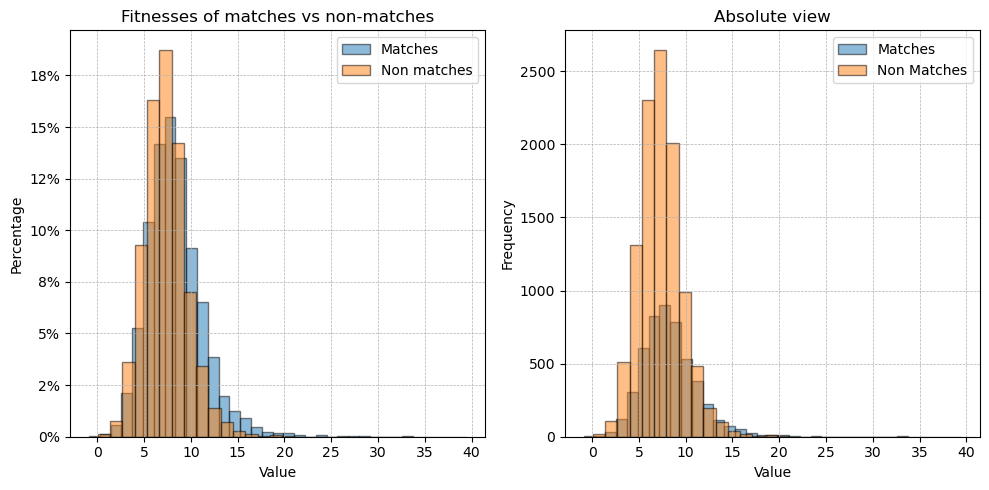

The metrics were (11, -10632, -0.8135571479797363, -0.8998644)
If you match this list of 11, with threshold 1:
{34, 643, 838, 267, 782, 144, 145, 179, 629, 790, 603}, gt=1
The Wasserstein distance is 1.1535118518182772
Distribution of match fitness
	n = 4448,
	average = 8.47, median = 8.07
	min = 0.18, max = 39.44,
	
Distribution of non match fitness
	n = 11350,
	average = 7.32, median = 7.18
	min = -0.89, max = 23.95,
	


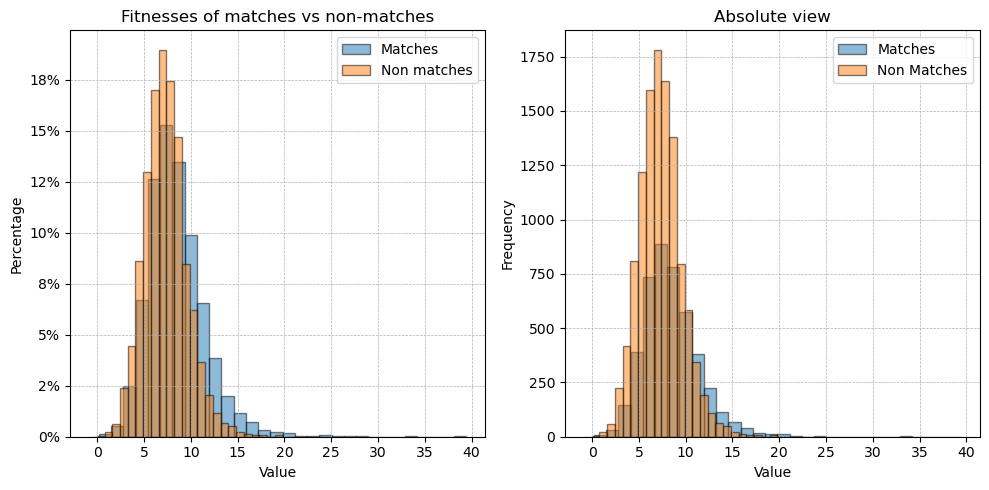

The metrics were (11, -13671, -0.7961862087249756, -0.5114409)
If you match this list of 11, with threshold 1:
{641, 321, 740, 297, 236, 332, 750, 530, 115, 404, 319}, gt=1
The Wasserstein distance is 0.97885611649365
Distribution of match fitness
	n = 5928,
	average = 8.25, median = 7.90
	min = 0.18, max = 39.44,
	
Distribution of non match fitness
	n = 9870,
	average = 7.27, median = 7.14
	min = -0.89, max = 23.95,
	


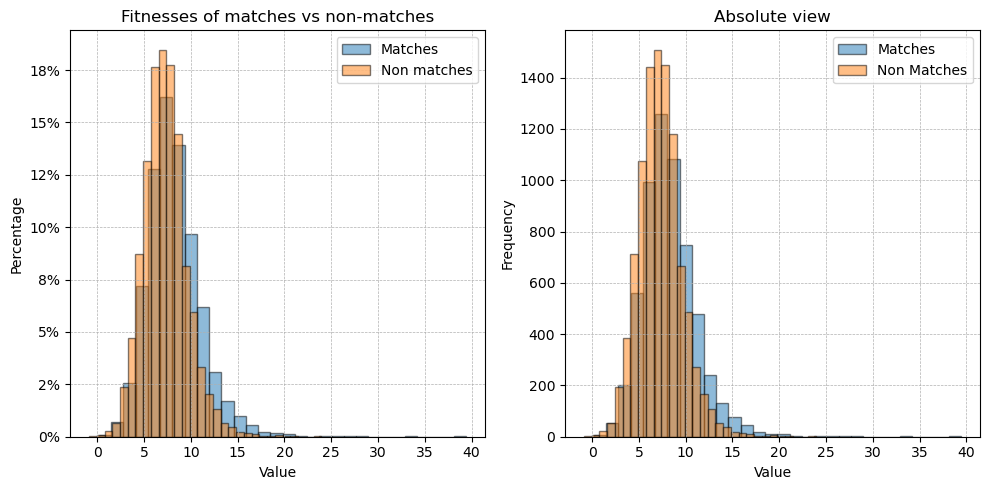

The metrics were (6, -10010, -0.7604763507843018, -1.5025071)
If you match this list of 6, with threshold 1:
{129, 852, 277, 842, 298, 750}, gt=1
The Wasserstein distance is 0.9689996810467584
Distribution of match fitness
	n = 4274,
	average = 8.35, median = 8.01
	min = 1.02, max = 33.75,
	
Distribution of non match fitness
	n = 11524,
	average = 7.38, median = 7.20
	min = -0.89, max = 39.44,
	


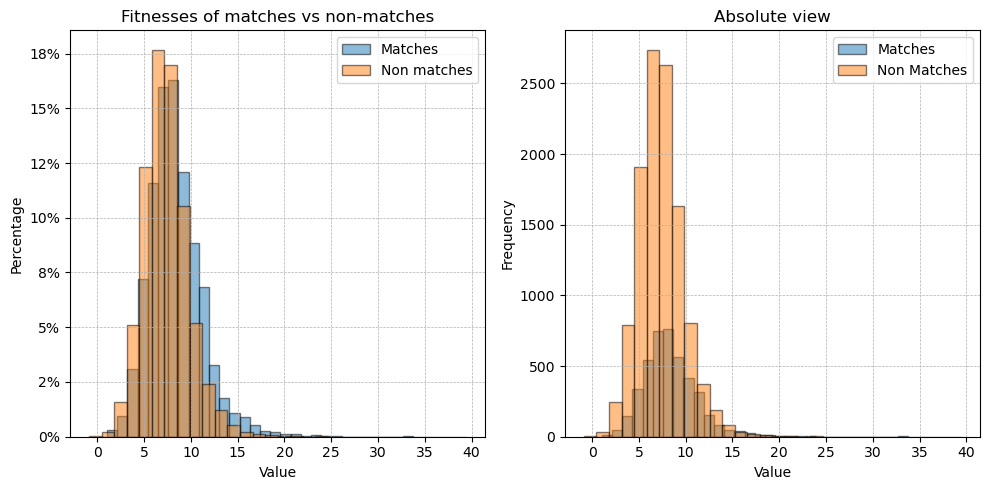

The metrics were (8, -14636, -0.6703798770904541, -0.114990644)
If you match this list of 8, with threshold 1:
{672, 804, 230, 807, 200, 460, 13, 915}, gt=1
The Wasserstein distance is 0.9204988921383097
Distribution of match fitness
	n = 6309,
	average = 8.19, median = 7.88
	min = -0.89, max = 39.44,
	
Distribution of non match fitness
	n = 9489,
	average = 7.27, median = 7.12
	min = 0.18, max = 23.95,
	


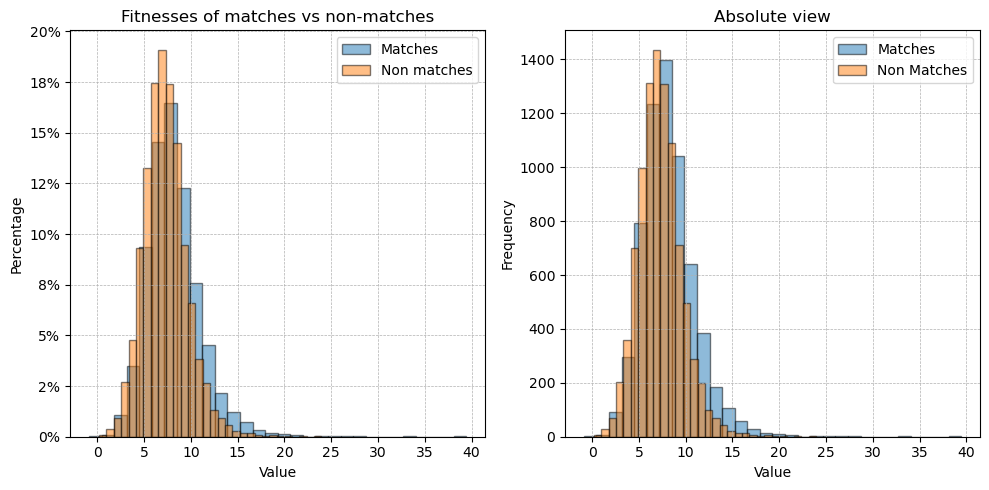

In [53]:
satisfactory_pss = results
for index, solution in enumerate(satisfactory_pss):
    print(index, solution.solution)

print(f"{len(satisfactory_pss)} are satisfactory out of {len(results)}")
        

for result in sorted(satisfactory_pss, key=lambda x: x.fitnesses[2], reverse=False)[::5]:
    print(f"The metrics were {result.fitnesses}")
    make_ps_into_explanation(result.solution, test_SPref=test_SPRef)

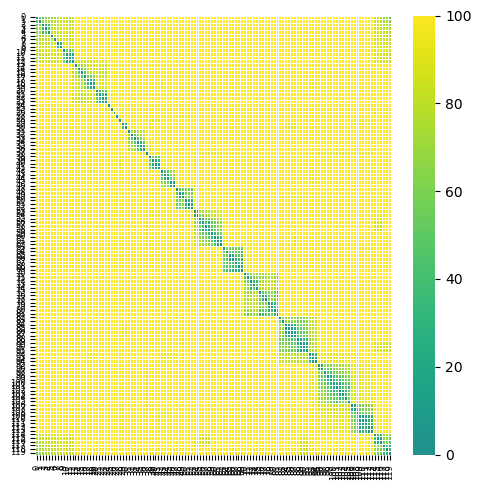

In [54]:


from initial_testing.understand_files.rearrange_linkage_table import clean_table
from collections import defaultdict



def distance_function(a: set, b: set):
    return 100 * len(set.union(a, b) - a.intersection(b)) / len(set.union(a, b))
    

to_show = satisfactory_pss
quantity = len(to_show)
distance_matrix = np.zeros(shape=(quantity, quantity), dtype=int)
for i, j in itertools.combinations(range(quantity), r=2):
    distance_matrix[i, j] = distance_function(to_show[i].solution, to_show[j].solution)


distance_matrix += distance_matrix.T

utils.show_matrix_with_colours(clean_table(distance_matrix), fig_size=(5, 5))



C:\Users\gac8\AppData\Local\Temp\ipykernel_12500\1072996255.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])


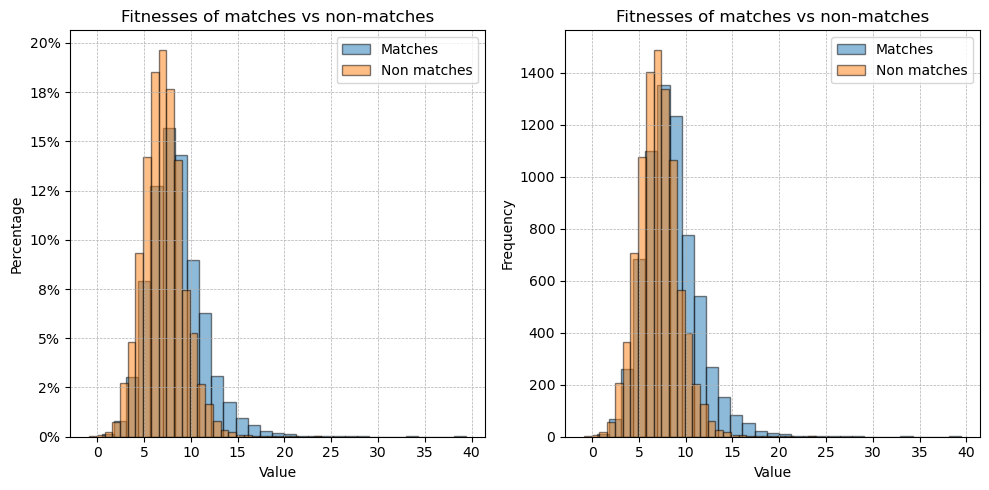

In [55]:
matches_by_any, non_matches_by_any = ([], [])


SPRef_to_get_from = test_SPRef
pss_to_consider = sorted(results, key=lambda x: x.fitnesses[2], reverse=False)[:25]
for session, fitness in zip(SPRef_to_get_from.sessions, SPRef_to_get_from.fitnesses):
    def matches_pattern(run_result):
        threshold = len(run_result.solution) if run_result.solution.genome_threshold is None else run_result.solution.genome_threshold
        return len(run_result.solution.intersection(session)) >= threshold
    if any(map(matches_pattern, pss_to_consider)):
        matches_by_any.append(fitness)
    else:
        non_matches_by_any.append(fitness)


display_side_by_side([
    {
        "data1": matches_by_any,
        "data2": non_matches_by_any,
        "title": f"Fitnesses of matches vs non-matches",
        "labels": ("Matches", "Non matches"),
        "y_axis_frequency": "relative"
    },
    {
        "data1": matches_by_any,
        "data2": non_matches_by_any,
        "title": f"Fitnesses of matches vs non-matches",
        "labels": ("Matches", "Non matches"),
        "y_axis_frequency": "absolute"
    },
])
            
    

In [56]:
# distribution of GT values

gt_counts = defaultdict(int)
for result in results:
    gt_counts[result.solution.genome_threshold] +=1 
    
print(gt_counts)

defaultdict(<class 'int'>, {2: 23, 1: 94, 3: 1, None: 2})
